In [1]:
#importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)

In [2]:
data1 = pd.read_csv('C:/Data_Science/Personal_Notebooks/Podcast_listening_time_prediction/train.csv')
data2 = pd.read_csv('C:/Data_Science/Personal_Notebooks/Podcast_listening_time_prediction/test.csv')

train = data1.copy()
test = data2.copy()

train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [3]:
train.isnull().sum(), test.isnull().sum()

(id                                  0
 Podcast_Name                        0
 Episode_Title                       0
 Episode_Length_minutes          87093
 Genre                               0
 Host_Popularity_percentage          0
 Publication_Day                     0
 Publication_Time                    0
 Guest_Popularity_percentage    146030
 Number_of_Ads                       1
 Episode_Sentiment                   0
 Listening_Time_minutes              0
 dtype: int64,
 id                                 0
 Podcast_Name                       0
 Episode_Title                      0
 Episode_Length_minutes         28736
 Genre                              0
 Host_Popularity_percentage         0
 Publication_Day                    0
 Publication_Time                   0
 Guest_Popularity_percentage    48832
 Number_of_Ads                      0
 Episode_Sentiment                  0
 dtype: int64)

In [4]:
train = train.fillna(train.median(numeric_only= True))
test = test.fillna(test.median(numeric_only= True))

In [5]:
num = train.select_dtypes(include='number')
cat = test.select_dtypes(exclude='number')

num.columns, cat.columns

(Index(['id', 'Episode_Length_minutes', 'Host_Popularity_percentage',
        'Guest_Popularity_percentage', 'Number_of_Ads',
        'Listening_Time_minutes'],
       dtype='object'),
 Index(['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day',
        'Publication_Time', 'Episode_Sentiment'],
       dtype='object'))

In [6]:
#lower case columns

def lower_case(data, cols= None):
    if cols == None:
        cols = data.columns
    data.rename(columns={col : col.lower() for col in cols}, inplace= True)

In [7]:
lower_case(num, ['id', 'Episode_Length_minutes', 'Host_Popularity_percentage',
        'Guest_Popularity_percentage', 'Number_of_Ads',
        'Listening_Time_minutes'])

lower_case(cat, ['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day',
        'Publication_Time', 'Episode_Sentiment'])

In [8]:
num = num.drop(columns='id')

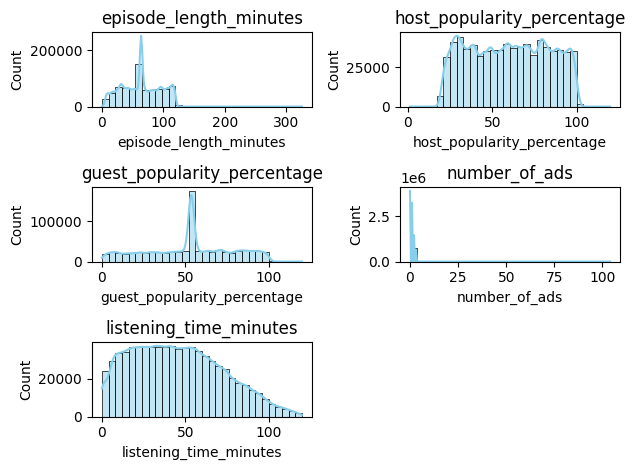

In [9]:
num1 = num.copy()

for i, column in enumerate(num1, 1):
    plt.subplot(3, 2, i)
    sns.histplot(num[column], kde=True, bins=30, color='skyblue', linewidth=0.5)
    plt.title(f'{column}')
    plt.tight_layout()

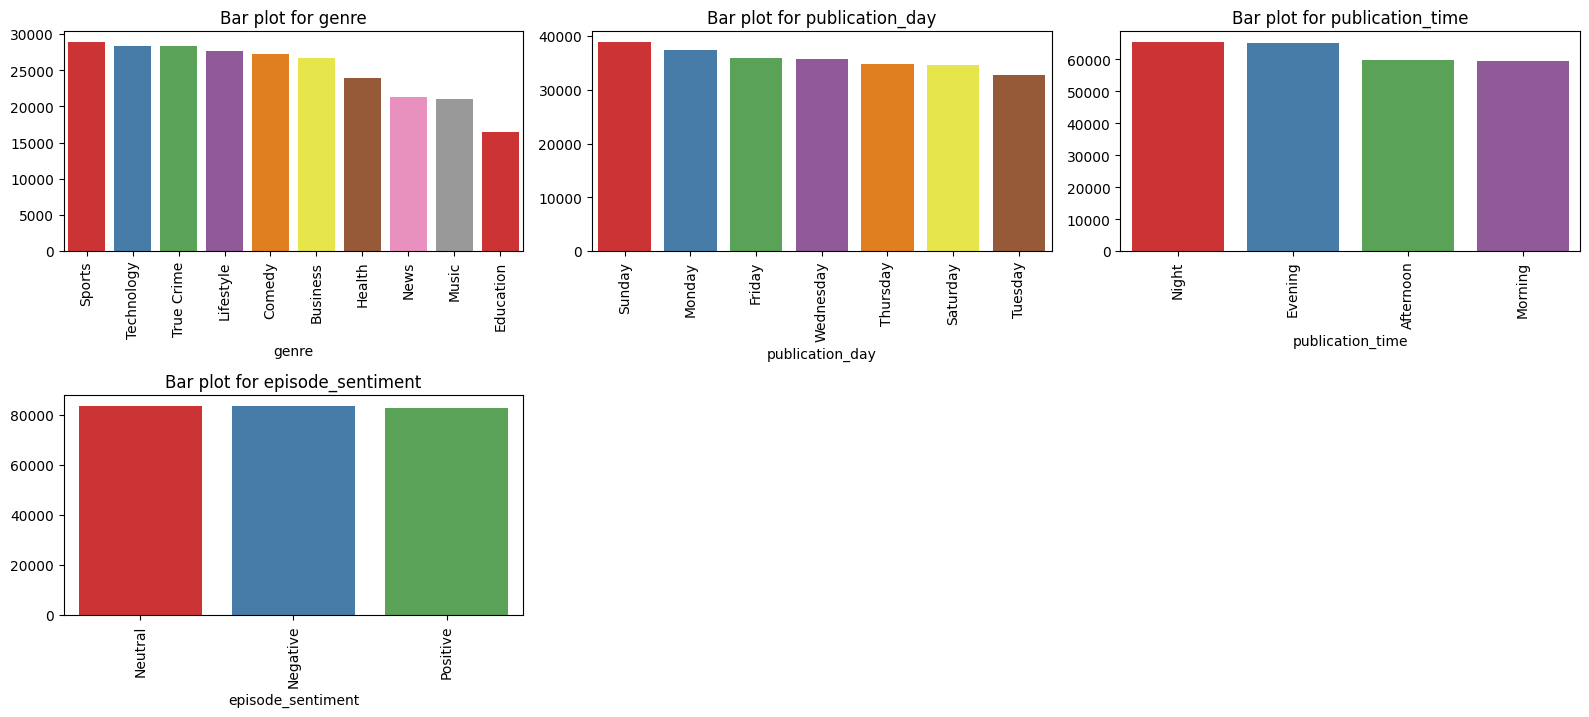

In [10]:
cat1 = cat.copy()

cat1 = cat1.drop(columns=['podcast_name', 'episode_title'])

plt.figure(figsize=(16, 10))
for i, column in enumerate(cat1, 1):
    plt.subplot(3, 3, i)
    sns.barplot(x=cat1[column].value_counts().index, y=cat1[column].value_counts().values, palette='Set1')
    plt.xticks(rotation=90)
    plt.title(f'Bar plot for {column}')
    plt.tight_layout()


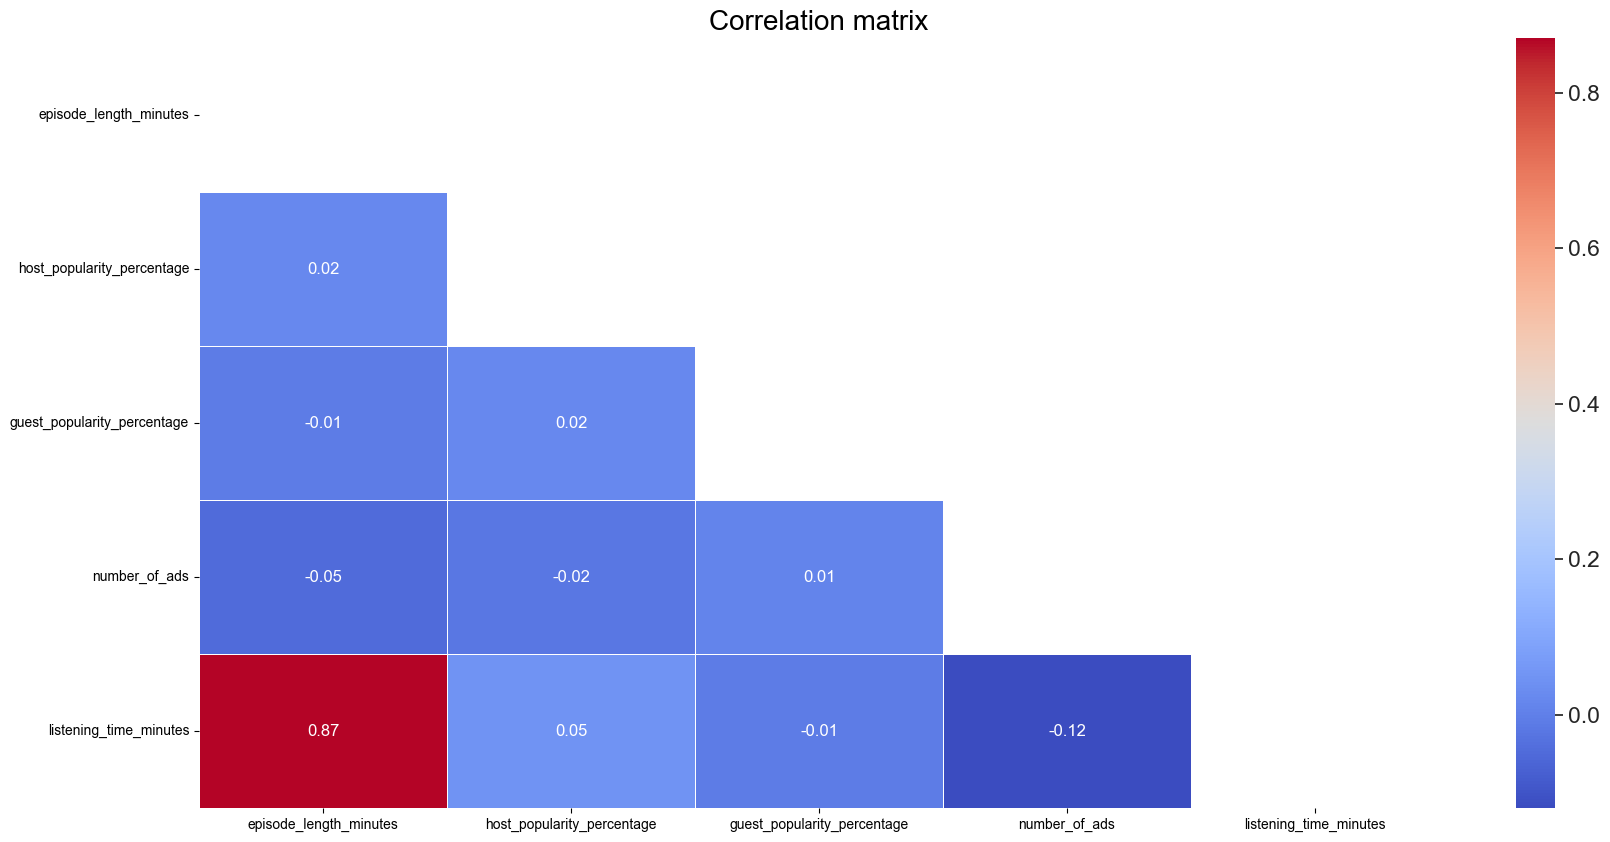

In [11]:
num_corr = round(num.corr(), 2)

# Correlation Matrix-Heatmap Plot
mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

f, ax = plt.subplots(figsize=(20, 10))
sns.set_theme(font_scale=1.5) # increase font size

ax = sns.heatmap(num_corr, mask=mask, annot=True, annot_kws={"size": 12}, linewidths=.5, cmap="coolwarm", fmt=".2f", ax=ax) # round to 2 decimal places
ax.set_title("Correlation matrix", fontsize=20) # add title
plt.show()


In [12]:
print(train['Publication_Time'])

0             Night
1         Afternoon
2           Evening
3           Morning
4         Afternoon
            ...    
749995      Morning
749996        Night
749997      Morning
749998      Morning
749999        Night
Name: Publication_Time, Length: 750000, dtype: object


In [13]:
train.columns, test.columns

(Index(['id', 'Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
        'Genre', 'Host_Popularity_percentage', 'Publication_Day',
        'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
        'Episode_Sentiment', 'Listening_Time_minutes'],
       dtype='object'),
 Index(['id', 'Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
        'Genre', 'Host_Popularity_percentage', 'Publication_Day',
        'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
        'Episode_Sentiment'],
       dtype='object'))

In [14]:
lower_case(train, ['Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
        'Genre', 'Host_Popularity_percentage', 'Publication_Day',
        'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
        'Episode_Sentiment', 'Listening_Time_minutes'])

lower_case(test, ['Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
        'Genre', 'Host_Popularity_percentage', 'Publication_Day',
        'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
        'Episode_Sentiment'])

In [15]:
days_encoding = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}

train['weekday_encoded'] = train['publication_day'].map(days_encoding)

test['weekday_encoded'] = test['publication_day'].map(days_encoding)

publication_encoding = {
    'Morning': 0,
    'Afternoon': 1,
    'Evening': 2,
    'Night': 4
}

train['publication_encoded'] = train['publication_time'].map(publication_encoding)

test['publication_encoded'] = test['publication_time'].map(publication_encoding)

train = train.drop(columns=['publication_day', 'publication_time'])

test = test.drop(columns=['publication_day', 'publication_time'])

print("Train df after encoding of day and time: \n", train.head(3))
print("Test df after encoding of day and time: \n", test.head(3))

Train df after encoding of day and time: 
    id     podcast_name episode_title  episode_length_minutes       genre  \
0   0  Mystery Matters    Episode 98                   63.84  True Crime   
1   1    Joke Junction    Episode 26                  119.80      Comedy   
2   2   Study Sessions    Episode 16                   73.90   Education   

   host_popularity_percentage  guest_popularity_percentage  number_of_ads  \
0                       74.81                        53.58            0.0   
1                       66.95                        75.95            2.0   
2                       69.97                         8.97            0.0   

  episode_sentiment  listening_time_minutes  weekday_encoded  \
0          Positive                31.41998                4   
1          Negative                88.01241                6   
2          Negative                44.92531                2   

   publication_encoded  
0                    4  
1                    1  
2          

In [16]:
episode_mapping = {
    'Negative': 0,
    'Neutral': 1,
    'Positive': 2
}

train['episode_sentiment_encoded'] = train['episode_sentiment'].map(episode_mapping)
test['episode_sentiment_encoded'] = test['episode_sentiment'].map(episode_mapping)

train = train.drop(columns='episode_sentiment')
test = test.drop(columns='episode_sentiment')

print("Train df after encoding the sentiment: \n", train.head(3))
print("Test df after encoding the sentiment: \n", test.head(3))

Train df after encoding the sentiment: 
    id     podcast_name episode_title  episode_length_minutes       genre  \
0   0  Mystery Matters    Episode 98                   63.84  True Crime   
1   1    Joke Junction    Episode 26                  119.80      Comedy   
2   2   Study Sessions    Episode 16                   73.90   Education   

   host_popularity_percentage  guest_popularity_percentage  number_of_ads  \
0                       74.81                        53.58            0.0   
1                       66.95                        75.95            2.0   
2                       69.97                         8.97            0.0   

   listening_time_minutes  weekday_encoded  publication_encoded  \
0                31.41998                4                    4   
1                88.01241                6                    1   
2                44.92531                2                    2   

   episode_sentiment_encoded  
0                          2  
1             

In [17]:
train

,id,podcast_name,episode_title,episode_length_minutes,genre,host_popularity_percentage,guest_popularity_percentage,number_of_ads,listening_time_minutes,weekday_encoded,publication_encoded,episode_sentiment_encoded
0,0,Mystery Matters,Episode 98,63.84,True Crime,74.81,53.58,0.0,31.41998,4,4,2
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,75.95,2.0,88.01241,6,1,0
2,2,Study Sessions,Episode 16,73.90,Education,69.97,8.97,0.0,44.92531,2,2,0
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,78.70,2.0,46.27824,1,0,2
4,4,Mind & Body,Episode 86,110.51,Health,80.07,58.68,3.0,75.61031,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,Learning Lab,Episode 25,75.66,Education,69.36,53.58,0.0,56.87058,6,0,0
749996,749996,Business Briefs,Episode 21,75.75,Business,35.21,53.58,2.0,45.46242,6,4,1
749997,749997,Lifestyle Lounge,Episode 51,30.98,Lifestyle,78.58,84.89,0.0,15.26000,4,0,0
749998,749998,Style Guide,Episode 47,108.98,Lifestyle,45.39,93.27,0.0,100.72939,4,0,0


In [18]:
genre_agg = train.copy()

genre_agg = genre_agg.groupby('genre')['listening_time_minutes'].mean()



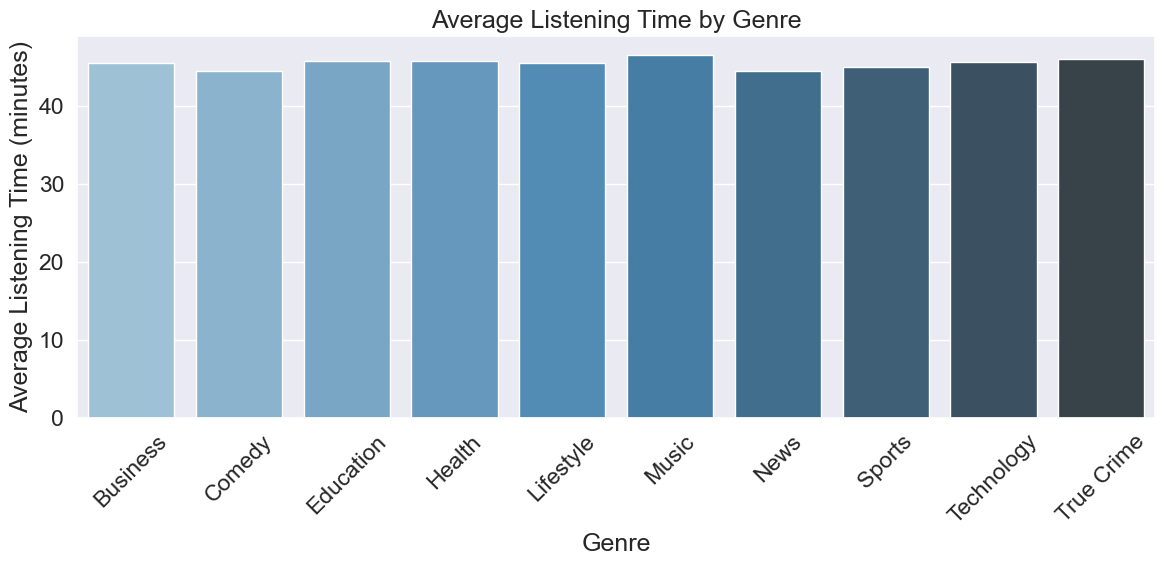

In [19]:
genre_agg = genre_agg.reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='genre', y='listening_time_minutes', data=genre_agg, palette='Blues_d')

plt.title('Average Listening Time by Genre')
plt.ylabel('Average Listening Time (minutes)')
plt.xlabel('Genre')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
train = train.drop(columns=['id','podcast_name', 'episode_title', 'genre'])
test = test.drop(columns=['id','podcast_name', 'episode_title', 'genre'])

In [27]:
target_placeholder = train.pop('listening_time_minutes')

train['listening_time_minutes'] = target_placeholder

train

,episode_length_minutes,host_popularity_percentage,guest_popularity_percentage,number_of_ads,weekday_encoded,publication_encoded,episode_sentiment_encoded,listening_time_minutes
0,63.84,74.81,53.58,0.0,4,4,2,31.41998
1,119.80,66.95,75.95,2.0,6,1,0,88.01241
2,73.90,69.97,8.97,0.0,2,2,0,44.92531
3,67.17,57.22,78.70,2.0,1,0,2,46.27824
4,110.51,80.07,58.68,3.0,1,1,1,75.61031
...,...,...,...,...,...,...,...,...
749995,75.66,69.36,53.58,0.0,6,0,0,56.87058
749996,75.75,35.21,53.58,2.0,6,4,1,45.46242
749997,30.98,78.58,84.89,0.0,4,0,0,15.26000
749998,108.98,45.39,93.27,0.0,4,0,0,100.72939


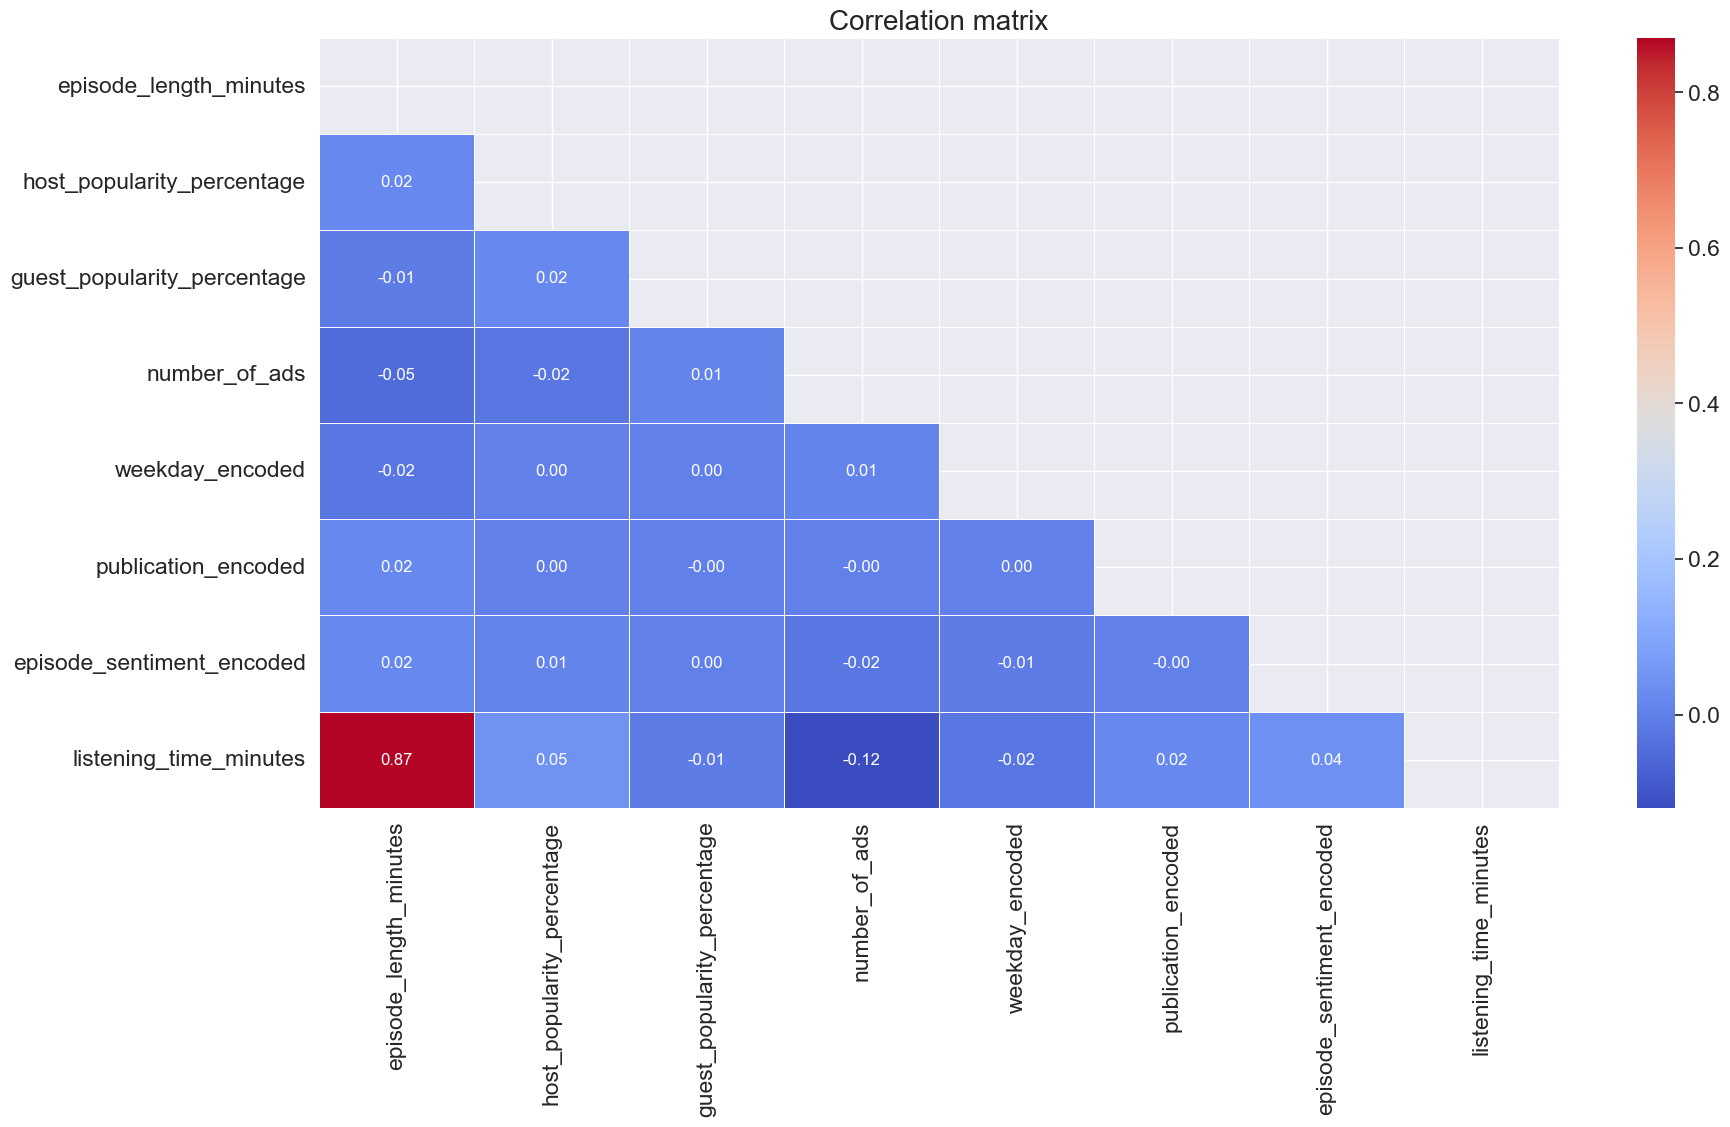

In [28]:
num_corr = round(train.corr(), 2)

# Correlation Matrix-Heatmap Plot
mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

f, ax = plt.subplots(figsize=(20, 10))
sns.set_theme(font_scale=1.5) # increase font size

ax = sns.heatmap(num_corr, mask=mask, annot=True, annot_kws={"size": 12}, linewidths=.5, cmap="coolwarm", fmt=".2f", ax=ax) # round to 2 decimal places
ax.set_title("Correlation matrix", fontsize=20) # add title
plt.show()


In [30]:
from sklearn.model_selection import train_test_split

X = train.drop(columns='listening_time_minutes') #target
y = train['listening_time_minutes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [33]:
def train_and_eval_models(X_train, X_test, y_train, y_test):

    #models to test
    models = {
        "Linear Regression" : LinearRegression(),
        "Random Forest" : RandomForestRegressor(),
        "XGB" : XGBRegressor()
    }

    print("Starting the training process.")

    #list to store results

    results = []

    #scaling data just for LogisticRegression

    for name, model in models.items():
        print(f"Training model: {name}")

        model.fit(X_train, y_train)

        y_train_predict = model.predict(X_train)
        y_test_predict = model.predict(X_test)

        results.append({
            "Model": name,
            "Train MAE": mean_absolute_error(y_train, y_train_predict),
            "Test MAE": mean_absolute_error(y_test, y_test_predict),
            "Train RMSE": np.sqrt(mean_squared_error(y_train, y_train_predict)),
            "Test RMSE": np.sqrt(mean_squared_error(y_test, y_test_predict)),
            "Train R2": r2_score(y_train, y_train_predict),
            "Test R2": r2_score(y_test, y_test_predict)
        })

    # Converting results into a DataFrame
    results_df = pd.DataFrame(results)

    print("\nModel Performance Summary:")
    print(results_df)

    return results_df

In [34]:
results_df = train_and_eval_models(X_train, X_test, y_train, y_test)

print(results_df)

Starting the training process.
Training model: Linear Regression
Training model: Random Forest
Training model: XGB

Model Performance Summary:
               Model  Train MAE  Test MAE  Train RMSE  Test RMSE  Train R2  \
0  Linear Regression   9.825678  9.775124   13.384001  13.352787  0.756830   
1      Random Forest   3.351914  9.019490    4.810727  12.826576  0.968583   
2                XGB   9.391536  9.477587   12.906652  13.044530  0.773866   

    Test R2  
0  0.757692  
1  0.776414  
2  0.768750  
               Model  Train MAE  Test MAE  Train RMSE  Test RMSE  Train R2  \
0  Linear Regression   9.825678  9.775124   13.384001  13.352787  0.756830   
1      Random Forest   3.351914  9.019490    4.810727  12.826576  0.968583   
2                XGB   9.391536  9.477587   12.906652  13.044530  0.773866   

    Test R2  
0  0.757692  
1  0.776414  
2  0.768750  


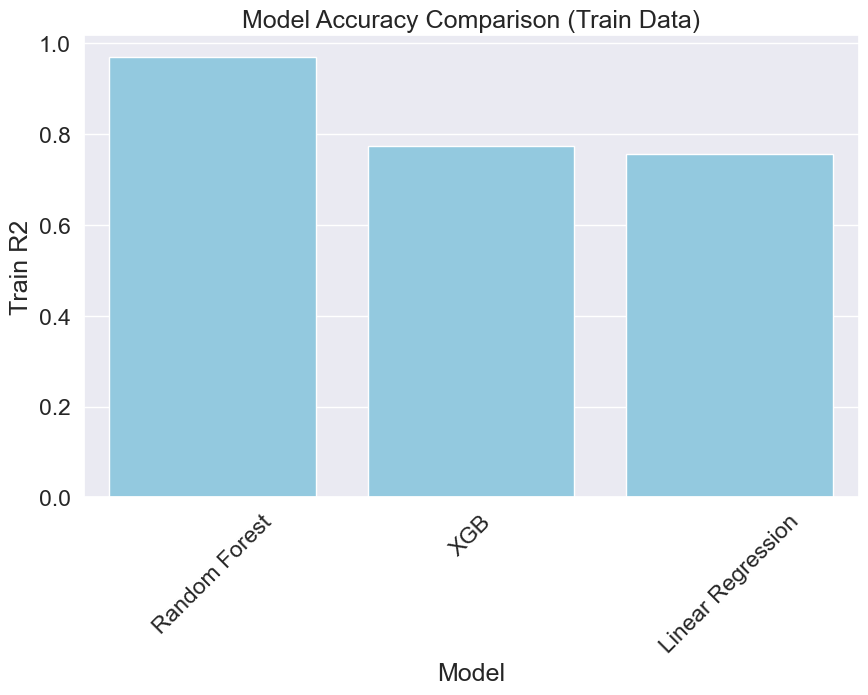

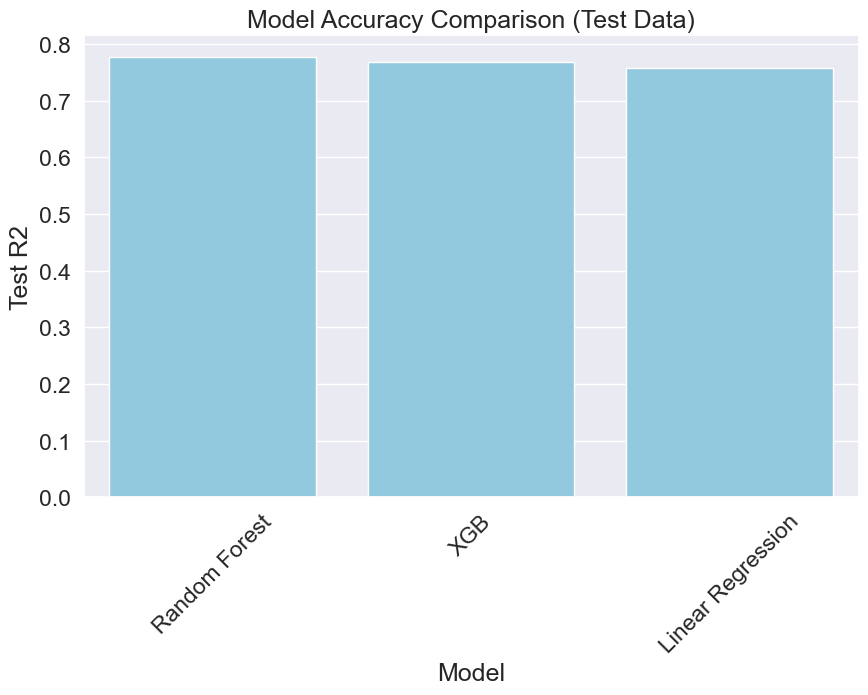

In [36]:
#plotting the results

plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Train R2", data=results_df.sort_values(by='Train R2', ascending=False), color='skyblue')
plt.title("Model Accuracy Comparison (Train Data)")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Test R2", data=results_df.sort_values(by='Test R2', ascending=False), color='skyblue')
plt.title("Model Accuracy Comparison (Test Data)")
plt.xticks(rotation=45)
plt.show()